## Initial setup
#### Imports

In [1]:
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scripts import settings
from scripts import utils
import xgboost as xgb
import pandas as pd
import numpy as np
import shap
import os

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#### Initial setup

In [2]:
settings.init_paths()

root_dir /Users/kevin/Desktop/stress


## Participants, filter names,  directories, and models
#### Variables

In [3]:
#participants_high_accuracy = ['aliceblackwood123@gmail.com', 'salman@nsl.inha.ac.kr', 'jumabek4044@gmail.com', 'nazarov7mu@gmail.com']
#participants_low_accuracy = ['laurentkalpers3@gmail.com', 'nnarziev@gmail.com', 'mr.khikmatillo@gmail.com']
participants_high_improvement = ['azizsambo58@gmail.com', 'nslabinha@gmail.com']
participants_low_improvement = ['jskim@nsl.inha.ac.kr', 'nnarziev@gmail.com']
participants_high_to_low_improvement = participants_high_improvement + participants_low_improvement
filter_datasets = {
    'no filter': settings.not_filtered_dataset_dir,
    'combined': settings.combined_filtered_dataset_dir,
    # 'ppg': settings.ppg_filtered_dataset_dir,
    # 'acc': settings.acc_filtered_dataset_dir
}
model_dirs = {
    'no filter': settings.not_filtered_model_dir,
    'combined': settings.combined_filtered_model_dir,
    # 'ppg': settings.settings.ppg_filtered_model_dir,
    # 'acc': settings.settings.acc_filtered_model_dir,
}
print('filter_datasets')
for i, filter_name in enumerate(filter_datasets.keys()):
    print(f'   {i}. {filter_name}\t{filter_datasets[filter_name]}')

print('model_dirs')
for i, filter_name in enumerate(model_dirs.keys()):
    print(f'   {i}. {filter_name}\t{model_dirs[filter_name]}')

filter_datasets
   0. no filter	/Users/kevin/Desktop/stress/data/processed dataset/1. not filtered dataset
   1. combined	/Users/kevin/Desktop/stress/data/processed dataset/4. combined filtered dataset
model_dirs
   0. no filter	/Users/kevin/Desktop/stress/data/models/1. not filtered
   1. combined	/Users/kevin/Desktop/stress/data/models/4. combined filtered


#### Train, test, and save data as files

In [5]:
# results = {}
# for filter_name in filter_datasets.keys():
#     results[filter_name] = []
#     if not os.path.exists(model_dirs[filter_name]):
#         os.mkdir(model_dirs[filter_name])
#     for participant in settings.participants:
#         # train models and get test features
#         all_models, all_test_features, all_test_scores, confusion_matrix = utils.participant_train_for_model(
#             participant=participant,
#             train_dir=filter_datasets[filter_name]
#         )
        
#         # create room/dir for files
#         if not os.path.exists(f'{model_dirs[filter_name]}/{participant}'):
#             os.mkdir(f'{model_dirs[filter_name]}/{participant}')
        
#         # save confusion matrix
#         with open(f'{model_dirs[filter_name]}/{participant}/confusion_matrix.csv', 'wb') as wb:
#             np.save(wb, confusion_matrix)
        
#         # save results
#         for i, sub_result in enumerate(zip(all_models, all_test_features, all_test_scores)):
#             # unpack
#             sub_model, sub_test_features, sub_test_scores = sub_result
#             # save model
#             sub_model.save_model(f'{model_dirs[filter_name]}/{participant}/{i}.model')
#             with open(f'{model_dirs[filter_name]}/{participant}/{i}.best_ntree_limit', 'w+') as w:
#                 w.write(str(sub_model.best_ntree_limit))
#             # save test features
#             sub_test_features.to_csv(f'{model_dirs[filter_name]}/{participant}/{i}.test_features.csv', index=False)
#             # save test scores
#             with open(f'{model_dirs[filter_name]}/{participant}/{i}.scores', 'w+') as w:
#                 w.write(f'{sub_test_scores[0]},{sub_test_scores[1]}')

The least populated class in y has only 4 members, which is less than n_splits=5.


#### Load stored data (e.g., models, test_features, etc.)

In [9]:
all_models = {}
all_test_features = {}
all_test_scores = {}
all_confusion_matrices = {}
all_model_best_ntree_limits = {}

for filter_name in filter_datasets.keys():
    all_models[filter_name] = {}
    all_test_features[filter_name] = {}
    all_test_scores[filter_name] = {}
    all_confusion_matrices[filter_name] = {}
    all_model_best_ntree_limits[filter_name] = {}
    for participant in participants_high_to_low_improvement:
        all_models[filter_name][participant] = []
        all_test_features[filter_name][participant] = []
        all_test_scores[filter_name][participant] = []
        all_model_best_ntree_limits[filter_name][participant] = []
        
        # load confusion matrix
        all_confusion_matrices[filter_name][participant] = np.load(f'{model_dirs[filter_name]}/{participant}/confusion_matrix.csv')
        
        # load models, test_features, and confusion matrix
        for filename in os.listdir(f'{model_dirs[filter_name]}/{participant}'):
            i = filename[:filename.index('.')]
            if filename.endswith('.model'):
                # load a model
                model = xgb.Booster({'nthread': 4})
                model.load_model(f'{model_dirs[filter_name]}/{participant}/{i}.model')
                all_models[filter_name][participant] += [model]
                with open(f'{model_dirs[filter_name]}/{participant}/{i}.best_ntree_limit', 'r') as r:
                    all_model_best_ntree_limits[filter_name][participant] += [int(r.read())]
            elif filename.endswith('.scores'):
                # load test scores
                with open(f'{model_dirs[filter_name]}/{participant}/{i}.scores', 'r') as r:
                    f1, roc_auc = r.read().split(',')
                    f1, roc_auc = float(f1), float(roc_auc)
                    all_test_scores[filter_name][participant] += [(f1, roc_auc)]
            elif filename.endswith('.test_features.csv'):
                # load test_features
                all_test_features[filter_name][participant] += [pd.read_csv(f'{model_dirs[filter_name]}/{participant}/{i}.test_features.csv')]

if len(all_models) == len(all_test_features) == len(all_test_scores) == len(all_model_best_ntree_limits):
    print('models loaded')
else:
    print('!inconsistency!')

models loaded


azizsambo58@gmail.com, no filter, f1=36.55, roc_auc=40.60


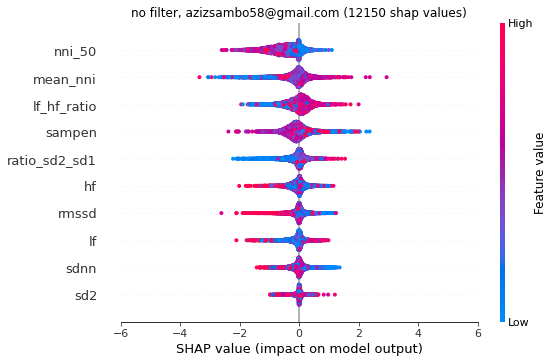

nslabinha@gmail.com, no filter, f1=43.04, roc_auc=48.29


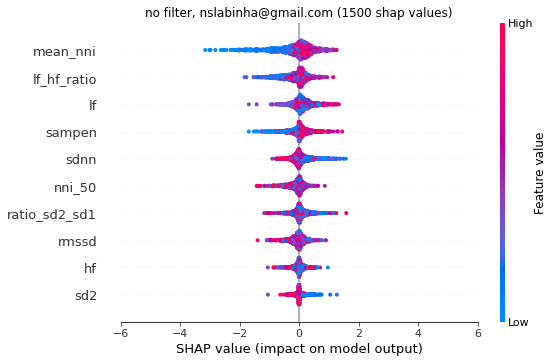

jskim@nsl.inha.ac.kr, no filter, f1=49.04, roc_auc=55.08


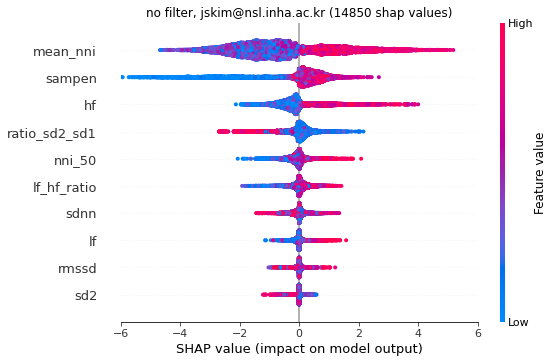

nnarziev@gmail.com, no filter, f1=44.56, roc_auc=49.14


KeyboardInterrupt: 

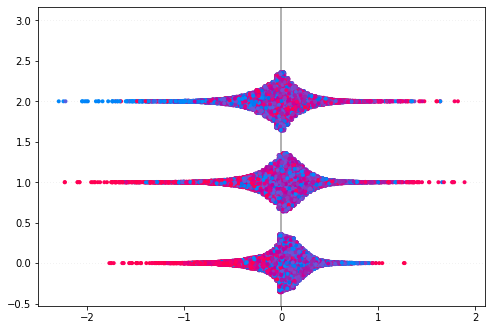

In [10]:
for filter_name in all_models.keys():
    for participant in all_models[filter_name].keys():
        # calculate shap values
        shap_values = []
        for sub_model, sub_test_features, sub_test_scores, sub_model_best_ntree_limit in zip(all_models[filter_name][participant], all_test_features[filter_name][participant], all_test_scores[filter_name][participant], all_model_best_ntree_limits[filter_name][participant]):
            tree_explainer = shap.TreeExplainer(sub_model)
            sub_shap_values = tree_explainer.shap_values(sub_test_features, tree_limit=sub_model_best_ntree_limit)
            shap_values += [sub_shap_values]
        shap_values = np.vstack(shap_values)
        test_features = pd.concat(all_test_features[filter_name][participant], axis=0)
        
        # print accuracy
        f1 = sum([f1 for f1, _ in all_test_scores[filter_name][participant]]) / len(all_test_scores)
        roc_auc = sum([roc_auc for _, roc_auc in all_test_scores[filter_name][participant]]) / len(all_test_scores)
        print(f'{participant}, {filter_name}, f1={f1:.2f}, roc_auc={roc_auc:.2f}')

        # plot shap summary plot - e.g., view all feature impacts to the tests
        shap.summary_plot(
            shap_values,
            test_features,
            sort=True,
            show=False
        )
        plt.xlim(-6, 6)
        plt.title(f'{filter_name}, {participant} ({len(shap_values)} shap values)')
        plt.show()
        
        # plot shap dependence plot - e.g., view correlation between impacts of two features
        # shap.dependence_plot(
        #     'mean_nni',
        #     shap_values,
        #     test_features,
        #     interaction_index='mean_nni',
        #     show=False
        # )
        # plt.ylim(-5, 5)
        # plt.title(f'{filter_name}, {participant} ({len(shap_values)} shap values)')
        # plt.show()